![eagle](../../eagleeye/eagle_eye_log.jpeg)


# Generate results

In [4]:
"""
@author: Andre Scaffidi (AndreScaffidi)
@author: Sebastian Springer (sspringe137)

This is a notebook to create figures 2 and 8 from the paper

"""

# Download the LHC Olympics R&D data from Zenodo if you don't have it already. 
# https://zenodo.org/records/4536377
# Can then use load_the_data.py to create the npy file we use for analysis. 
# Current data file is in ./data/LHC_data1p1M_new_features.npy so don't need to do this step

!wget https://zenodo.org/records/6466204/files/events_anomalydetection_v2.features.h5?download=1 .
!mv 'events_anomalydetection_v2.features.h5?download=1' data/events_anomalydetection_v2.features.h5


--2024-10-29 11:07:20--  https://zenodo.org/records/6466204/files/events_anomalydetection_v2.features.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74315238 (71M) [application/octet-stream]
Saving to: ‘events_anomalydetection_v2.features.h5?download=1’

events_anomalydetec 100%[===================>]  70.87M  36.9MB/s    in 1.9s    

2024-10-29 11:07:22 (36.9 MB/s) - ‘events_anomalydetection_v2.features.h5?download=1’ saved [74315238/74315238]

--2024-10-29 11:07:22--  http://./
Resolving . (.)... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2024-10-29 11:07:22--
Total wall clock time: 2.3s
Downloaded: 1 files, 71M in 1.9s (36.9 MB/s)


In [ ]:
"""
Read the data and partitian the features as per Sec. 3.2 of the paper.
The result is a numpy array with columns corresponding to 
['|p|1', '|p|2', 'tau21j1', 'tau21j2', 'tau32j1', 'tau32j2' , 'mj1', 'mj2', 'label']
"""
import pandas as pd
import numpy as np

file_path              = 'data/events_anomalydetection_v2.features.h5'
df_features            = pd.read_hdf(file_path)
# Feature engineering
df_features['|p|1']    = np.sqrt(np.sum(df_features[['pxj1', 'pyj1', 'pzj1']]**2, axis=1))
df_features['|p|2']    = np.sqrt(np.sum(df_features[['pxj2', 'pyj2', 'pzj2']]**2, axis=1))
df_features['tau21j1'] = df_features['tau2j1']/df_features['tau1j1']
df_features['tau21j2'] = df_features['tau2j2']/df_features['tau1j2']
df_features['tau32j1'] = df_features['tau3j1']/df_features['tau2j1']
df_features['tau32j2'] = df_features['tau3j2']/df_features['tau2j2']

new_features           = ['|p|1', '|p|2', 'tau21j1', 'tau21j2', 'tau32j1', 'tau32j2']
df_features            = df_features[new_features + [col for col in df_features.columns if col not in new_features]]

LHC_data1p1M           = df_features.to_numpy()[ :, [0,1,2,3,4,5,9,16,20] ]

LHC_data1p1M[np.isnan(LHC_data1p1M)]                  = 0    

np.save('data/LHC_data1p1M_new_features.npy',LHC_data1p1M)

In [17]:
"""
Run EagleEye

Here we have created the script 'run.sh' to run 'LHC_Olympics2020_EagleEye_DADM.py', which calls EagleEye and performs the anomaly detection
itteratevly over several anomaly injection percentages. 

Results are saved in the 'results' folder. 

NOTE: This process can require several CPU hours**
"""

!bash run.sh



Running with anomaly size: 2500
^C


# Read results



In [1]:
# Load the res dictionary from the pickle file
import pickle
import numpy as np
anomaly_possibilities = [10000, 2500, 1750, 1500, 1400, 1300, 1250, 1100, 1000, 500, 0]
results = {}
for dat in anomaly_possibilities:
    with open(f'./results/LHC_EagleEye_res_500000_anomaly_size_%d_kstar_range_20_999.pkl' % dat, 'rb') as f:
        res_loaded = pickle.load(f)
        results[dat] = res_loaded

In [2]:
# First row plotting just teh test and reference as well as just the signal points
mixed_samples10k    = results[10000]['stats']['mixed_samples']
filtered_samples10k = results[10000]['stats']['mixed_samples'][results[10000]['stats']['lables_mix'] == 1]
mixed_samples2_5k   = results[2500]['stats']['mixed_samples']
filtered_samples2_5k= results[2500]['stats']['mixed_samples'][results[2500]['stats']['lables_mix'] == 1]
mixed_samples1_5k   = results[1500]['stats']['mixed_samples']
filtered_samples1_5k= results[1500]['stats']['mixed_samples'][results[1500]['stats']['lables_mix'] == 1]

In [4]:
import sys
sys.path.append('../../eagleeye')
import EagleEye as EagleEye
import utils_EE 
import importlib
importlib.reload(EagleEye)
quant                        = 0
clusters_10000               = utils_EE.partitioning_function(results[10000]['stats']['reference_samples'],results[10000]['stats']['mixed_samples'],results[10000],p_ext=1e-5,Z=1.65)
repechage_EE_book10000       = EagleEye.Repechage(results[10000]['stats']['reference_samples'],results[10000]['stats']['mixed_samples'],results[10000],clusters_10000,p_ext=1e-05,quant=quant)

clusters_2500                = utils_EE.partitioning_function(results[2500]['stats']['reference_samples'],results[2500]['stats']['mixed_samples'],results[2500],p_ext=1e-5,Z=1.65)
repechage_EE_book2500        = EagleEye.Repechage(results[2500]['stats']['reference_samples'],results[2500]['stats']['mixed_samples'],results[2500],clusters_2500,p_ext=1e-05,quant=quant)

clusters_1500                = utils_EE.partitioning_function(results[1500]['stats']['reference_samples'],results[1500]['stats']['mixed_samples'],results[1500],p_ext=1e-5,Z=1.65)
repechage_EE_book1500        = EagleEye.Repechage(results[1500]['stats']['reference_samples'],results[1500]['stats']['mixed_samples'],results[1500],clusters_1500,  p_ext=1e-05,quant=quant)

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1
alpha = 2


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1
alpha = 2
alpha = 3


'DONE!'

<IPython.core.display.Math object>

alpha = 1
alpha = 2


'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1
alpha = 2
alpha = 3


'DONE!'

<IPython.core.display.Math object>

alpha = 1
alpha = 2


'DONE!'

In [6]:
# Get the pruned and repechaged sets for the diferent clusters that are identiied
Upsilon_alpha_plus_1500 = min([repechage_EE_book1500['Y_OVER_clusters'][x]['Upsilon_alpha_plus']   for x in range(len(repechage_EE_book2500['Y_OVER_clusters']))]) 
Putative_1500           = [repechage_EE_book1500['Y_OVER_clusters'][x]['Putative']   for x in range(len(repechage_EE_book1500['Y_OVER_clusters']))]
Pruned_1500             = [repechage_EE_book1500['Y_OVER_clusters'][x]['Pruned']     for x in range(len(repechage_EE_book1500['Y_OVER_clusters']))]
Repechaged_1500         = [repechage_EE_book1500['Y_OVER_clusters'][x]['Repechaged'] for x in range(len(repechage_EE_book1500['Y_OVER_clusters']))] 
Background_1500         = [repechage_EE_book1500['Y_OVER_clusters'][x]['Background'] for x in range(len(repechage_EE_book1500['Y_OVER_clusters']))] 

Upsilon_alpha_plus_2500 =  min([repechage_EE_book2500['Y_OVER_clusters'][x]['Upsilon_alpha_plus']   for x in range(len(repechage_EE_book1500['Y_OVER_clusters']))])
Putative_2500           = [repechage_EE_book2500['Y_OVER_clusters'][x]['Putative']   for x in range(len(repechage_EE_book2500['Y_OVER_clusters']))] 
Pruned_2500             = [repechage_EE_book2500['Y_OVER_clusters'][x]['Pruned']     for x in range(len(repechage_EE_book2500['Y_OVER_clusters']))] 
Repechaged_2500         = [repechage_EE_book2500['Y_OVER_clusters'][x]['Repechaged'] for x in range(len(repechage_EE_book2500['Y_OVER_clusters']))]  
Background_2500         = [repechage_EE_book2500['Y_OVER_clusters'][x]['Background'] for x in range(len(repechage_EE_book2500['Y_OVER_clusters']))]  

Upsilon_alpha_plus_10000 = min([repechage_EE_book10000['Y_OVER_clusters'][x]['Upsilon_alpha_plus']   for x in range(len(repechage_EE_book10000['Y_OVER_clusters']))])
Putative_10000           = [repechage_EE_book10000['Y_OVER_clusters'][x]['Putative']   for x in range(len(repechage_EE_book10000['Y_OVER_clusters']))] 
Pruned_10000             = [repechage_EE_book10000['Y_OVER_clusters'][x]['Pruned']     for x in range(len(repechage_EE_book10000['Y_OVER_clusters']))]
Repechaged_10000         = [repechage_EE_book10000['Y_OVER_clusters'][x]['Repechaged'] for x in range(len(repechage_EE_book10000['Y_OVER_clusters']))]  
Background_10000         = [repechage_EE_book10000['Y_OVER_clusters'][x]['Background'] for x in range(len(repechage_EE_book10000['Y_OVER_clusters']))]  

# Table 2 (Section 3.2)

In [7]:
# Signal purity: Estimate and 'True' (from known simulation labels)

import numpy as np
import pandas as pd
# Equation 8
def S_SB_estimate(dict,repechage_EE_book):
    over_clusters  = repechage_EE_book["Y_OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['Repechaged'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['Background'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['Pruned'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']] for idx in list(over_clusters.keys())])

    under_clusters =  repechage_EE_book["X_OVER_clusters"]
    lenWu          =  len(np.concatenate([under_clusters[idx]['Pruned'] for idx in list(under_clusters.keys())]))
    S_SB = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_SB = S_SB / lenSo
    S_SB = {'Total' : S_SB}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['Repechaged'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['Background'])
        lenWo          =  len(over_clusters[idx]['Pruned'])
        S_SB[idx] = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu))
        S_SB[idx] = S_SB[idx] / lenSo
        Upsilon_xi[idx] = min(dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']])
    return S_SB,Upsilon_xi

def S_SB_True(dict,repechage_EE_book,Upsilon_star_plus=14):
    over_clusters  = repechage_EE_book["Y_OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y']>Upsilon_star_plus) & (l==1)]
    b   = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y']>Upsilon_star_plus) & (l==0)]
    S_SB = len(s)/(len(s)+len(b))
    S_SB = {'Total' : S_SB}
    SoUpsilons     =  np.concatenate([dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['Repechaged'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']])
        s = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['Repechaged'])]
        b = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['Repechaged'])]
        S_SB[idx] = len(s)/(len(s)+len(b))
    return S_SB

# Euqation 11
def S_rootB_estimate(dict,repechage_EE_book):
    over_clusters  = repechage_EE_book["Y_OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['Repechaged'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['Background'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['Pruned'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']] for idx in list(over_clusters.keys())])

    under_clusters =  repechage_EE_book["X_OVER_clusters"]
    lenWu          =  len(np.concatenate([under_clusters[idx]['Pruned'] for idx in list(under_clusters.keys())]))
    S_B = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_B = S_B / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
    S_B = {'Total' : S_B}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['Repechaged'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['Background'])
        lenWo          =  len(over_clusters[idx]['Pruned'])
        S_B[idx] = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu))
        S_B[idx] = S_B[idx] / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
        Upsilon_xi[idx] = min(dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']])
    return S_B,Upsilon_xi

def S_rootB_True(dict,repechage_EE_book,Upsilon_star_plus=14):
    over_clusters  = repechage_EE_book["Y_OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y']>Upsilon_star_plus) & (l==1)]
    b   = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y']>Upsilon_star_plus) & (l==0)]
    S_B = len(s)/np.sqrt(len(b))
    S_B = {'Total' : S_B}
    SoUpsilons     =  np.concatenate([dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['Repechaged'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']])
        s = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['Repechaged'])]
        b = dict['Upsilon_i_Y'][(dict['Upsilon_i_Y'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['Repechaged'])]
        S_B[idx] = len(s)/np.sqrt(len(b))
    return S_B


### Create the dataframes for the metrics
#################################################
def calc_metrics(res_dict,repechage_EE_book):
    S_SB_est,upsilons = S_SB_estimate(res_dict, repechage_EE_book)
    S_SB_true         = S_SB_True(res_dict, repechage_EE_book, Upsilon_star_plus=upsilons['Total'])
    S_B_est,upsilons  = S_rootB_estimate(res_dict, repechage_EE_book)
    S_B_true          = S_rootB_True(res_dict, repechage_EE_book, Upsilon_star_plus=upsilons['Total'])
    return {r"$\mathbf{\Upsilon}^+_\alpha$" : upsilons , r"$\widehat{\frac{S_\alpha}{\sqrt{B_\alpha}}}$" : S_B_est, r"$\frac{S_\alpha}{\sqrt{B_\alpha}}^\textrm{Truth}$" : S_B_true, r"$\widehat{\frac{S_\alpha}{S_\alpha+B_\alpha}}$" : S_SB_est, r"$\frac{S_\alpha}{S_\alpha+B_\alpha}^\textrm{Truth}$" : S_SB_true  } # Testing

def calc_metrics_df(res_dict, repechage_EE_book,Upsilon_star_plus=14):
    # Call your existing function to compute metrics (which returns dicts of dicts)
    metrics = calc_metrics(res_dict, repechage_EE_book)
    idx = list(next(iter(metrics.values())).keys())
    idx_labels = {ix: r"$\alpha = %d$" % ix if ix != 'Total' else 'Total' for ix in idx}
    df = pd.DataFrame(index=idx)
    for metric_name, metric_dict in metrics.items():
        df[metric_name] = pd.Series(metric_dict)
    df.rename(index=idx_labels, inplace=True)
    return df
def multi_metrics_df_to_latex(dfs, experiment_names=None):
    import pandas as pd
    if isinstance(dfs, dict):
        experiment_names = list(dfs.keys())
        dfs = list(dfs.values())

    if experiment_names is None:
        experiment_names = [f'Exp {i+1}' for i in range(len(dfs))]

    df_list = []
    for name, df in zip(experiment_names, dfs):
        df_copy = df.copy()
        df_copy[r"$\alpha$"] = df_copy.index  # use the index as the $\alpha$ column.
        df_copy["Anomaly percentage"] = name
        df_list.append(df_copy.reset_index(drop=True))
    
    combined = pd.concat(df_list, ignore_index=True)
    
    cols = [r"$\alpha$", "Anomaly percentage"] + [col for col in combined.columns if col not in [r"$\alpha$", "Anomaly percentage"]]
    combined = combined[cols]
    
    # Latex formatting for paper
    lines = []
    lines.append(r"\begin{table}")
    lines.append(r"\centering")
    lines.append(r"\label{tab:metrics}")
    col_format = "ll" + "r"*(len(combined.columns)-2)
    lines.append(r"\begin{tabular}{" + col_format + "}")
    lines.append(r"\hline")
    
    header = " & ".join(combined.columns) + r" \\"
    lines.append(header)
    lines.append(r"\hline")

    for i, row in combined.iterrows():
        cells = []
        is_total_row = str(row[combined.columns[0]]).strip().lower() == "total"
        for j, col in enumerate(combined.columns):
            value = row[col]
            if isinstance(value, (float, int)):
                cell = f"{value:.2f}"
                if is_total_row:
                    cell = r"\textbf{" + cell + "}"
            else:
                cell = str(value)
                if j == 0 and cell.strip().lower() == "total":
                    cell = r"\textbf{" + cell + "}"
            cells.append(cell)
        line = " & ".join(cells) + r" \\"
        lines.append(line)
    
        if i < len(combined) - 1:
            current_anom = row["Anomaly percentage"]
            next_anom = combined.iloc[i+1]["Anomaly percentage"]
            if current_anom != next_anom:
                lines.append(r"\hline")
               
    lines.append(r"\hline")
    lines.append(r"\end{tabular}")
    lines.append(r"\caption{Estimated and truth level per-anomaly ($\alpha$) signal-to-background metrics  for the three anomaly percentage benchmarks shown in Fig.~\ref{fig:LHC_locations}. The 'Total' signal-to-background is calculated by making the substitution $\test^\text{anom}_\alpha \rightarrow \cup_\alpha \test^\text{anom}_\alpha$ and $\test^\text{inj}_\alpha \rightarrow \cup_\alpha \test^\text{inj}_\alpha$ in Eqns.~\ref{eq:s/s+b}and~\ref{eqn:s/b}.}")
    lines.append(r'\label{tab:metrics}')
    lines.append(r"\end{table}")
    
    return "\n".join(lines)




In [8]:
from IPython.display import display, Markdown
df1 = calc_metrics_df(results[1500],repechage_EE_book1500)
df2 = calc_metrics_df(results[2500],repechage_EE_book2500)
df3 = calc_metrics_df(results[10000],repechage_EE_book10000)
print("0.3%")
display(Markdown(df1.to_markdown()))
print("0.5%")
display(Markdown(df2.to_markdown()))
print("2%")
display(Markdown(df3.to_markdown()))
dfs = {"0.3\%": df1, "0.5\%": df2, "2\%": df3}
latex_code = multi_metrics_df_to_latex(dfs)
print(latex_code)

0.3%


|              |   $\mathbf{\Upsilon}^+_\alpha$ |   $\widehat{\frac{S_\alpha}{\sqrt{B_\alpha}}}$ |   $\frac{S_\alpha}{\sqrt{B_\alpha}}^\textrm{Truth}$ |   $\widehat{\frac{S_\alpha}{S_\alpha+B_\alpha}}$ |   $\frac{S_\alpha}{S_\alpha+B_\alpha}^\textrm{Truth}$ |
|:-------------|-------------------------------:|-----------------------------------------------:|----------------------------------------------------:|-------------------------------------------------:|------------------------------------------------------:|
| Total        |                        14.2621 |                                       3.28653  |                                             5.62989 |                                        0.375018  |                                              0.54     |
| $\alpha = 1$ |                        14.9085 |                                       6.49986  |                                             7.50555 |                                        0.7647    |                                              0.8125   |
| $\alpha = 2$ |                        14.2621 |                                       0.392232 |                                             2.75    |                                        0.0714286 |                                              0.407407 |

0.5%


|              |   $\mathbf{\Upsilon}^+_\alpha$ |   $\widehat{\frac{S_\alpha}{\sqrt{B_\alpha}}}$ |   $\frac{S_\alpha}{\sqrt{B_\alpha}}^\textrm{Truth}$ |   $\widehat{\frac{S_\alpha}{S_\alpha+B_\alpha}}$ |   $\frac{S_\alpha}{S_\alpha+B_\alpha}^\textrm{Truth}$ |
|:-------------|-------------------------------:|-----------------------------------------------:|----------------------------------------------------:|-------------------------------------------------:|------------------------------------------------------:|
| Total        |                        14.0095 |                                        23.6695 |                                             22.6223 |                                         0.610057 |                                              0.594549 |
| $\alpha = 1$ |                        14.0784 |                                        17.9368 |                                             16.3255 |                                         0.638669 |                                              0.607774 |
| $\alpha = 2$ |                        14.0095 |                                        15.4158 |                                             15.7792 |                                         0.578679 |                                              0.587248 |

2%


|              |   $\mathbf{\Upsilon}^+_\alpha$ |   $\widehat{\frac{S_\alpha}{\sqrt{B_\alpha}}}$ |   $\frac{S_\alpha}{\sqrt{B_\alpha}}^\textrm{Truth}$ |   $\widehat{\frac{S_\alpha}{S_\alpha+B_\alpha}}$ |   $\frac{S_\alpha}{S_\alpha+B_\alpha}^\textrm{Truth}$ |
|:-------------|-------------------------------:|-----------------------------------------------:|----------------------------------------------------:|-------------------------------------------------:|------------------------------------------------------:|
| Total        |                        14.0706 |                                        83.9457 |                                             85.4045 |                                         0.555682 |                                              0.5606   |
| $\alpha = 0$ |                        14.2853 |                                        61.4035 |                                             61.0964 |                                         0.568736 |                                              0.567051 |
| $\alpha = 1$ |                        14.0706 |                                        56.8527 |                                             60.0266 |                                         0.539529 |                                              0.558099 |

\begin{table}
\centering
\label{tab:metrics}
\begin{tabular}{llrrrrr}
\hline
$\alpha$ & Anomaly percentage & $\mathbf{\Upsilon}^+_\alpha$ & $\widehat{\frac{S_\alpha}{\sqrt{B_\alpha}}}$ & $\frac{S_\alpha}{\sqrt{B_\alpha}}^\textrm{Truth}$ & $\widehat{\frac{S_\alpha}{S_\alpha+B_\alpha}}$ & $\frac{S_\alpha}{S_\alpha+B_\alpha}^\textrm{Truth}$ \\
\hline
\textbf{Total} & 0.3\% & \textbf{14.26} & \textbf{3.29} & \textbf{5.63} & \textbf{0.38} & \textbf{0.54} \\
$\alpha = 1$ & 0.3\% & 14.91 & 6.50 & 7.51 & 0.76 & 0.81 \\
$\alpha = 2$ & 0.3\% & 14.26 & 0.39 & 2.75 & 0.07 & 0.41 \\
\hline
\textbf{Total} & 0.5\% & \textbf{14.01} & \textbf{23.67} & \textbf{22.62} & \textbf{0.61} & \textbf{0.59} \\
$\alpha = 1$ & 0.5\% & 14.08 & 17.94 & 16.33 & 0.64 & 0.61 \\
$\alpha = 2$ & 0.5\% & 14.01 & 15.42 & 15.78 & 0.58 & 0.59 \\
\hline
\textbf{Total} & 2\% & \textbf{14.07} & \textbf{83.95} & \textbf{85.40} & \textbf{0.56} & \textbf{0.56} \\
$\alpha = 0$ & 2\% & 14.29 & 61.40 & 61.10 & 0.57 & 0.57 \\
$\alpha =

# Figure 2 (Section 3.2)

In [ ]:
# Compute null from binomial trials to save as npy file
import utils_EE as utils
Upsilon_i_plus_null = utils.compute_the_null(0.5,1000)
with open('Upsilon_i_plus_null.pkl', 'wb') as f:
    pickle.dump(Upsilon_i_plus_null, f)


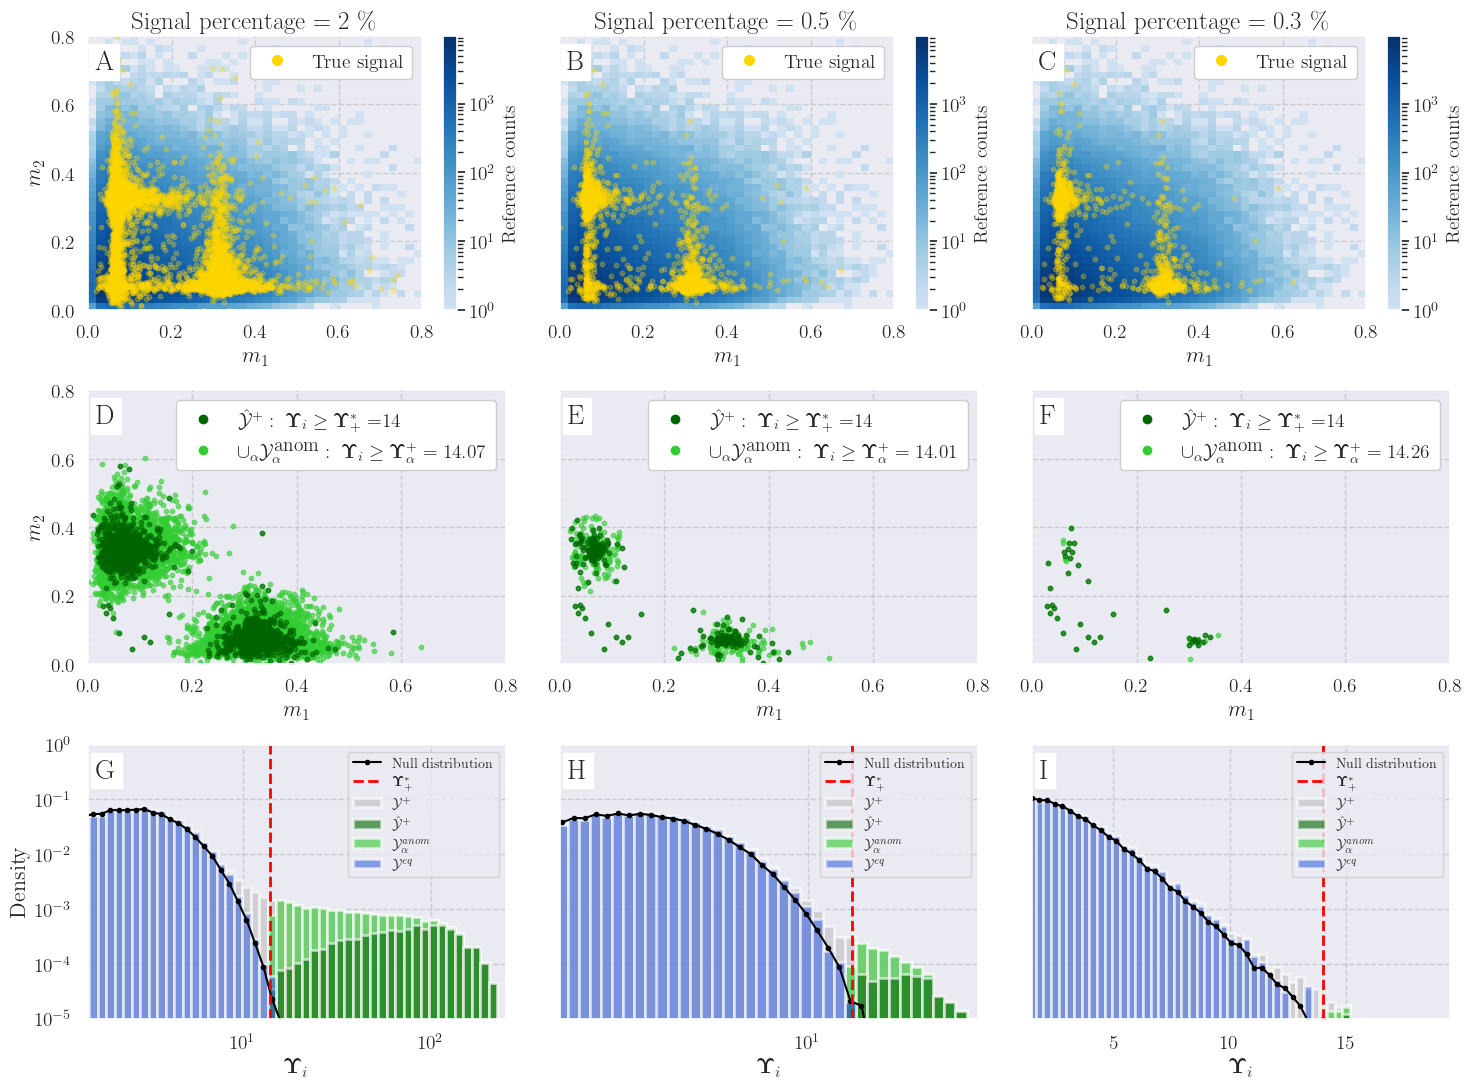

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

def set_custom_style():
    sns.set(style="darkgrid")
    plt.rcParams.update({
        'figure.figsize': (22, 25),
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'font.family': 'serif',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'grid.color': 'gray',
        'text.usetex': True,
    })
set_custom_style()
features = [6,7]
colors = ['royalblue', 'limegreen', 'darkgreen', 'silver', 'red']
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15, 12))
axislim = [0, 0.8]

#############
## First Row
lllim = 14 # Set the initial threshold that was used in the paper
first_row_label = "True signal"
cbar_label_top = 'Reference counts'

first_row_cmap='Blues'
original_cmap = plt.get_cmap('Blues')

first_row_cmap = LinearSegmentedColormap.from_list(
    'first_row_cmap', 
    original_cmap(np.linspace(0.2, 1, 256))
)
true_sig_color = 'gold'
heatmap = axs[0, 0].hist2d(mixed_samples10k[:, features[0]], mixed_samples10k[:, features[1]], bins=50, cmap=first_row_cmap, norm=LogNorm())
cbar00 = plt.colorbar(heatmap[3], ax=axs[0, 0], norm=LogNorm())
cbar00.set_label(cbar_label_top, fontsize=14)
axs[0, 0].scatter(filtered_samples10k[:,     features[0]], filtered_samples10k[:,    features[1]], s=10.0, c=true_sig_color, alpha=0.3)
darker_dot = Line2D([0], [0], marker='o', linestyle='None',color=true_sig_color, markerfacecolor=true_sig_color, markersize=7, label=first_row_label)
axs[0, 0].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 0].set_xlim(axislim)
axs[0, 0].set_ylim(axislim)

heatmap = axs[0, 1].hist2d(mixed_samples2_5k[:, features[0]], mixed_samples2_5k[:, features[1]], bins=50, cmap=first_row_cmap, norm=LogNorm())
cbar10 = plt.colorbar(heatmap[3], ax=axs[0, 1], norm=LogNorm())
cbar10.set_label(cbar_label_top, fontsize=14)
axs[0, 1].scatter(filtered_samples2_5k[:,     features[0]], filtered_samples2_5k[:,    features[1]], s=10.0, c=true_sig_color, alpha=0.3, label=first_row_label)
darker_dot = Line2D([0], [0], marker='o', linestyle='None',color=true_sig_color, markerfacecolor=true_sig_color, markersize=7, label=first_row_label)
axs[0, 1].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 1].set_xlim(axislim)
axs[0, 1].set_ylim(axislim)
heatmap = axs[0, 2].hist2d(mixed_samples1_5k[:, features[0]], mixed_samples1_5k[:, features[1]], bins=50, cmap=first_row_cmap, norm=LogNorm())
cbar20 = plt.colorbar(heatmap[3], ax=axs[0, 2], norm=LogNorm())
cbar20.set_label(cbar_label_top, fontsize=14)
axs[0, 2].scatter(filtered_samples1_5k[:,     features[0]], filtered_samples1_5k[:,    features[1]], s=10.0, c=true_sig_color, alpha=0.3, label=first_row_label)
darker_dot = Line2D([0], [0], marker='o', linestyle='None',color=true_sig_color, markerfacecolor=true_sig_color, markersize=7, label=first_row_label)
axs[0, 2].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 2].set_xlim(axislim)
axs[0, 2].set_ylim(axislim)
vmin,vmax = 0,40
greek = r'\mathbf{\Upsilon}'



#################
# 2nd Row
def plot_second_row(ax, repechage, pruned , results_dict,Upsilon_alpha_plus):
    # Plot Repechaged
    for cluster in repechage:
        ax.scatter(
            results_dict['stats']['mixed_samples'][cluster, features[0]],
            results_dict['stats']['mixed_samples'][cluster, features[1]],
            c='limegreen',
            s=10,
            alpha=0.6
        )
    # Plot Pruned
    for cluster in pruned:
        ax.scatter(
            results_dict['stats']['mixed_samples'][cluster, features[0]],
            results_dict['stats']['mixed_samples'][cluster, features[1]],
            c='darkgreen',
            s=10,
            alpha=0.6
        )
    # Custom legend
    handles = []
    So = Line2D([0], [0], marker='o', color='limegreen', linestyle='None',
                label=r"$\cup_\alpha\mathcal{Y}^\textrm{anom}_\alpha:\; \mathbf{\Upsilon}_i \geq \mathbf{\Upsilon}^+_\alpha=%1.2F$ " % (Upsilon_alpha_plus))
    Wo = Line2D([0], [0], marker='o', color='darkgreen', linestyle='None',
                label=r"$\hat{\mathcal{Y}}^+:\; \mathbf{\Upsilon}_i \geq \mathbf{\Upsilon}^*_+=$%d" % lllim)
    handles.extend([Wo, So])
    ax.legend(handles=handles, facecolor='white', framealpha=1, markerscale=1)
    ax.set_xlim(axislim)
    ax.set_ylim(axislim)

plot_second_row(axs[1, 0], Repechaged_10000, Pruned_10000, results[10000],Upsilon_alpha_plus_10000)
plot_second_row(axs[1, 1], Repechaged_2500, Pruned_2500, results[2500],Upsilon_alpha_plus_2500)
plot_second_row(axs[1, 2], Repechaged_1500, Pruned_1500, results[1500],Upsilon_alpha_plus_1500)

#################
# 3rd Row
import plot_utils_lhc
importlib.reload(plot_utils_lhc)

# Load the null data from the pickle file
with open('Upsilon_i_plus_null.pkl', 'rb') as f:
    Upsilon_i_plus_null = pickle.load(f)
Upsilon_i_plus_null = Upsilon_i_plus_null[0.5]

np.random.seed(42)
plot_utils_lhc.plot_third_subplot(axs[2, 0],
                       results[10000]['Upsilon_i_Y'],
                       Upsilon_i_plus_null,
                       14,
                       Upsilon_set_equalized = np.random.choice(results[0]['Upsilon_i_Y'], 100000, replace=False),
                       Upsilon_set_repechage=results[10000]['Upsilon_i_Y'][np.concatenate(Repechaged_10000)],
                       Upsilon_set_pruned=results[10000]['Upsilon_i_Y'][np.concatenate(Pruned_10000)],
                       n_bins=100,
                       legend = True,
                       xlog=True)
np.random.seed(2)
plot_utils_lhc.plot_third_subplot(axs[2, 1],
                       results[2500]['Upsilon_i_Y'],
                       Upsilon_i_plus_null,
                       14,
                       Upsilon_set_equalized = np.random.choice(results[0]['Upsilon_i_Y'], 100000, replace=False),
                       Upsilon_set_repechage=results[2500]['Upsilon_i_Y'][np.concatenate(Repechaged_2500)],
                       Upsilon_set_pruned=results[2500]['Upsilon_i_Y'][np.concatenate(Pruned_2500)],
                       n_bins=100,
                       legend = True,
                       xlog=True)
np.random.seed(4)
plot_utils_lhc.plot_third_subplot(axs[2, 2],
                       results[1500]['Upsilon_i_Y'],
                       Upsilon_i_plus_null,
                       14,
                       Upsilon_set_equalized = np.random.choice(results[0]['Upsilon_i_Y'], 100000, replace=False),
                       Upsilon_set_repechage=results[1500]['Upsilon_i_Y'][np.concatenate(Repechaged_1500)],
                       Upsilon_set_pruned=results[1500]['Upsilon_i_Y'][np.concatenate(Pruned_1500)],
                       n_bins=60,
                       legend = True,
                       xlog=False)


#################################################
# Axis adjusting
for ax in axs[:, 1:].flat:
    ax.set_yticklabels([])

# Adding labels to each subplot
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
for ax, label in zip(axs.flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left', zorder=10, bbox=dict(facecolor='white', edgecolor='white'))

# Main titles for the figure
axs[1, 0].set_xlabel(r'$m_{1}$')
axs[1, 1].set_xlabel(r'$m_{1}$')
axs[1, 2].set_xlabel(r'$m_{1}$') 

axs[1, 0].set_xlabel(r'$m_{1}$')
axs[1, 1].set_xlabel(r'$m_{1}$')
axs[1, 2].set_xlabel(r'$m_{1}$') 

axs[0, 0].set_xlabel(r'$m_{1}$')
axs[0, 1].set_xlabel(r'$m_{1}$')
axs[0, 2].set_xlabel(r'$m_{1}$') 

axs[2, 0].set_xlabel(r'$%s_i$'%greek)
axs[2, 1].set_xlabel(r'$%s_i$'%greek)
axs[2, 2].set_xlabel(r'$%s_i$'%greek) 

axs[0, 0].set_ylabel(r'$m_{2}$')
# axs[1, 0].set_ylabel(r'$m_{2}$')
axs[1, 0].set_ylabel(r'$m_{2}$')
axs[2, 0].set_ylabel(r'$\textrm{Density}$')

axs[0, 0].set_title(r'Signal percentage = %d \%%'%      plot_utils_lhc.percentage_of_anomaly(10E3)) 
axs[0, 1].set_title(r'Signal percentage = %.1f $\%%$' % plot_utils_lhc.percentage_of_anomaly(2.5E3))
axs[0, 2].set_title(r'Signal percentage = %.1f $\%%$' % plot_utils_lhc.percentage_of_anomaly(1.5E3))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to include the main title
plt.savefig('Plots/LHC_anom_location.png')
plt.show()

# Figure 8 (Supplementary Information) 


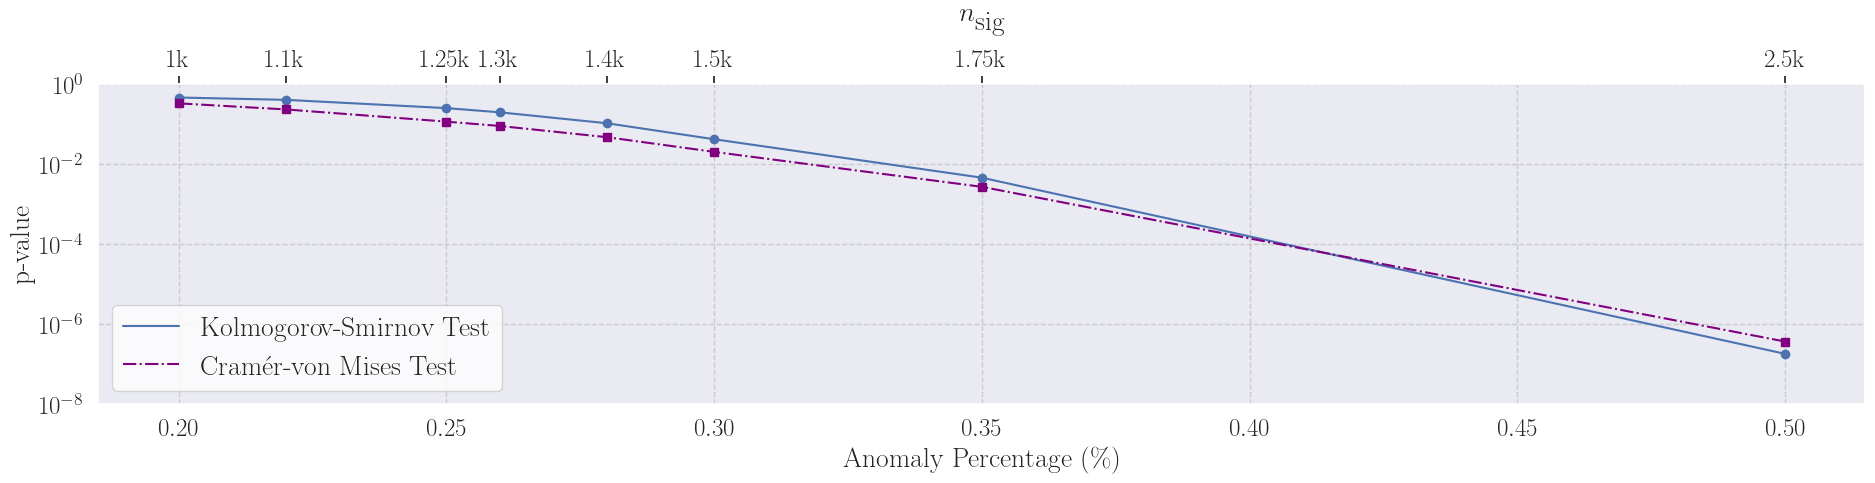

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, cramervonmises_2samp
import seaborn as sns
import matplotlib.lines as mlines


dist_list = [
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[2500]['Upsilon_i_Y'],results[2500]['Upsilon_i_X']]),  2.5E3 , plot_utils_lhc.percentage_of_anomaly(2.5E3 ) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1750]['Upsilon_i_Y'],results[1750]['Upsilon_i_X']]), 1.75E3, plot_utils_lhc.percentage_of_anomaly(1.75E3) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1500]['Upsilon_i_Y'],results[1500]['Upsilon_i_X']]),  1.5E3 , plot_utils_lhc.percentage_of_anomaly(1.5E3 ) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1400]['Upsilon_i_Y'],results[1400]['Upsilon_i_X']]),  1.4E3 , plot_utils_lhc.percentage_of_anomaly(1.4E3 ) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1300]['Upsilon_i_Y'],results[1300]['Upsilon_i_X']]),  1.3E3 , plot_utils_lhc.percentage_of_anomaly(1.3E3 ) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1250]['Upsilon_i_Y'],results[1250]['Upsilon_i_X']]), 1.25E3, plot_utils_lhc.percentage_of_anomaly(1.25E3) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1100]['Upsilon_i_Y'],results[1100]['Upsilon_i_X']]),  1.1E3 , plot_utils_lhc.percentage_of_anomaly(1.1E3 ) ),
(np.concatenate([results[0]['Upsilon_i_Y'],results[0]['Upsilon_i_X']]), np.concatenate([results[1000]['Upsilon_i_Y'],results[1000]['Upsilon_i_X']]),   1E3   , plot_utils_lhc.percentage_of_anomaly(1E3   ) ),
]

def ks_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    ks_stat, p_value = ks_2samp(s_binary, b_binary)
    return p_value /2 

# Add a function for Cramér-von Mises test
def cvm_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    result = cramervonmises_2samp(s_binary, b_binary)
    return result.pvalue /2

# Modify plot_pvalues_vs_anomaly_percentage to include Cramér-von Mises p-value
def plot_pvalues_vs_anomaly_percentage(lnP_s_list, lnP_b_list, anomaly_percentages, threshold, color):
    ks_pvalues  = []
    ad_pvalues  = []
    mi_pvalues  = []
    cvm_pvalues = []  # Store Cramér-von Mises p-values

    for lnP_s, lnP_b in zip(lnP_s_list, lnP_b_list):
        ks_pvalues.append(ks_test_pvalue(lnP_s, lnP_b, threshold))
        cvm_pvalues.append(cvm_test_pvalue(lnP_s, lnP_b, threshold))  # Append Cramér-von Mises p-value

    return ks_pvalues, cvm_pvalues

# Plotting
lnP_s_list          = [x[1] for x in dist_list]
lnP_b_list          = [x[0] for x in dist_list]
anomaly_percentages = [x[3] for x in dist_list]
anomaly_sizes       = [x[2] for x in dist_list]

colors = ['b', 'g', 'r', 'c', 'm', 'orange']

def set_custom_style():
    sns.set(style="darkgrid")
    plt.rcParams.update({
        'figure.figsize': (22, 20),
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 14,
        'font.family': 'serif',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'grid.color': 'gray',
        'text.usetex': True,
    })

set_custom_style()

fig, ax1 = plt.subplots(figsize=(19, 5))
ax1.set_ylim(1E-12, 5)

for i, threshold in enumerate([0]):    
    ks_pvalues, cvm_pvalues = plot_pvalues_vs_anomaly_percentage(lnP_s_list, lnP_b_list, anomaly_percentages, threshold, colors[i % len(colors)])
    ax1.plot(anomaly_percentages, ks_pvalues, marker='o', linestyle='-', color=colors[i % len(colors)], label=fr'KS')
    ax1.plot(anomaly_percentages, cvm_pvalues, marker='s', linestyle='-.', color='purple', label=fr'CVM')  # Plot Cramér-von Mises p-values

secax = ax1.secondary_xaxis('top')
secax.set_xlabel(r'$n_\textrm{sig}$', labelpad=20)
secax.set_xticks(anomaly_percentages[::-1])
secax.set_xticklabels(['1k', '1.1k', '1.25k', '1.3k', '1.4k', '1.5k', '1.75k', '2.5k'])

ax1.set_xlabel('Anomaly Percentage (\\%)')
ax1.set_ylabel('p-value')
ax1.set_yscale('log')

# ax1.axhline(y=0.01, color='k', linestyle='--', label=r'$p=0.05$')

# Custom legend handles
line1 = mlines.Line2D([], [], color='b', linestyle='-', label='Kolmogorov-Smirnov Test')
line2 = mlines.Line2D([], [], color='purple', linestyle='-.', label='Cramér-von Mises Test')
line4 = mlines.Line2D([], [], color='k', linestyle='--', label=r'$p_\textrm{thresh} = 0.05$')

# ax1.legend(facecolor='white', handles=[line1, line2, line4], loc='lower left', fontsize=20)
ax1.legend(facecolor='white', handles=[line1, line2], loc='lower left', fontsize=20)

plt.tight_layout()
plt.ylim(1E-8,1)
plt.savefig('Plots/pvalues_vs_anomaly_percentage.pdf')
plt.show()
